In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval

# for word embeddings
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec

# for BERT
import torch
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer

# for graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\suyat\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
# prevent lists from being converted to strings
processed_train = pd.read_csv("Data/processed_train.csv", 
    usecols=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'text_tokenized_nopunc', 'clean_text'],
    converters={'text_tokenized_nopunc': literal_eval})
processed_train.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,text_tokenized_nopunc
0,0000997932d777bf,0,0,0,0,0,0,explanation why the edits made under my userna...,"[explanation, why, the, edits, made, under, my..."
1,000103f0d9cfb60f,0,0,0,0,0,0,d'aww! he matches this background colour i am ...,"[daww, he, matches, this, background, colour, ..."
2,000113f07ec002fd,0,0,0,0,0,0,"hey man, i am really not trying to edit war. i...","[hey, man, i, am, really, not, trying, to, edi..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,""" more i cannot make any real suggestions on i...","[more, i, cannot, make, any, real, suggestions..."
4,0001d958c54c6e35,0,0,0,0,0,0,"you, sir, are my hero. any chance you remember...","[you, sir, are, my, hero, any, chance, you, re..."


In [11]:
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
processed_train['none'] = 1 - processed_train[LABELS].max(axis=1)

Embedding methods can convert a text input to a numeric vector, which can be used as the features of our machine learning models.

In [ ]:
def get_glove_embedding(data):
    # define a helper function to calculate the embedding vector of each text
    def get_embeddings(vectors, text, k, generate_missing=False):
        # dealing with empty text
        if len(text)<1:
            return np.zeros(k)
        # generate randomized vectors for unseen words if generate_missing is True
        if generate_missing:
            vectorized = [vectors[word][:k] if word in vectors else np.random.rand(k) for word in text]
        # represent unseen words with 0 vector if generate_missing is False
        else:
            vectorized = [vectors[word][:k] if word in vectors else np.zeros(k) for word in text]
        # each text is represented by averaging the vectors of its constituent words
        length = len(vectorized)
        summed = np.sum(vectorized, axis=0)
        averaged = np.divide(summed, length)
        return averaged
    
    # build a GloVe model
    print('building glove model')
    glove_model = gensim.models.KeyedVectors.load_word2vec_format("glove.twitter.27B.200d.txt.word2vec", binary=False, limit=1190000)
    
    # generate embedding vectors of size 200 using tokenized text (stop words kept)
    print('generating embedding vectors')
    embeddings_glove = data["text_tokenized_nopunc"].map(lambda x: get_embeddings(glove_model, x, 200))
    
    return embeddings_glove

## Word Embedding

There are some decisions we need to make:
- should stop words and punctuations be removed before embedding
- custom embeddings or pre-trained embeddings or embedding layer
- for pre-trained embeddings, which package to use: Word2Vec/GloVe, FastText, BERT
- the size of vector to represent each text
- word embedding or sentence embedding

In [28]:
# define a helper function to calculate the embedding vector of each text
def get_embeddings(vectors, text, k, generate_missing=False):
    # dealing with empty text
    if len(text)<1:
        return np.zeros(k)
    # generate randomized vectors for unseen words if generate_missing is True
    if generate_missing:
        vectorized = [vectors[word][:k] if word in vectors else np.random.rand(k) for word in text]
    # represent unseen words with 0 vector if generate_missing is False
    else:
        vectorized = [vectors[word][:k] if word in vectors else np.zeros(k) for word in text]
    # each text is represented by averaging the vectors of its constituent words
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

### Global Vectors for Word Representation (GloVe)

Similar to Word2Vec method, each word is presented by a high dimension vector and trained based on the surrounding words over a huge corpus. Since our project works on Tweets, we apply a pre-trained word embedding trained over Twitter content (https://github.com/stanfordnlp/GloVe).

Advantages:
- It captures the position of the words in the text (syntactic)
- It captures meaning in the words (semantics)

Limitations:
- It cannot capture the meaning of the word from the text (fails to capture polysemy)
- It cannot capture out-of-vocabulary words from corpus

In [ ]:
# generate a word2vec file used for model building - 200d
glove_input_file = "D:/GoogleDownloads/BT4222/glove.twitter.27B/glove.twitter.27B.200d.txt"
word2vec_output_file = "glove.twitter.27B.200d.txt.word2vec"
glove2word2vec(glove_input_file, word2vec_output_file)

In [4]:
# build a GloVe model
glove_model = gensim.models.KeyedVectors.load_word2vec_format("glove.twitter.27B.200d.txt.word2vec", binary=False, limit=1190000) 

In [6]:
# generate embedding vectors of size 200 using tokenized text (stop words kept)
# side note: map function outperforms for loop
embeddings_glove = processed_train["text_tokenized_nopunc"].map(lambda x: get_embeddings(glove_model, x, 200))

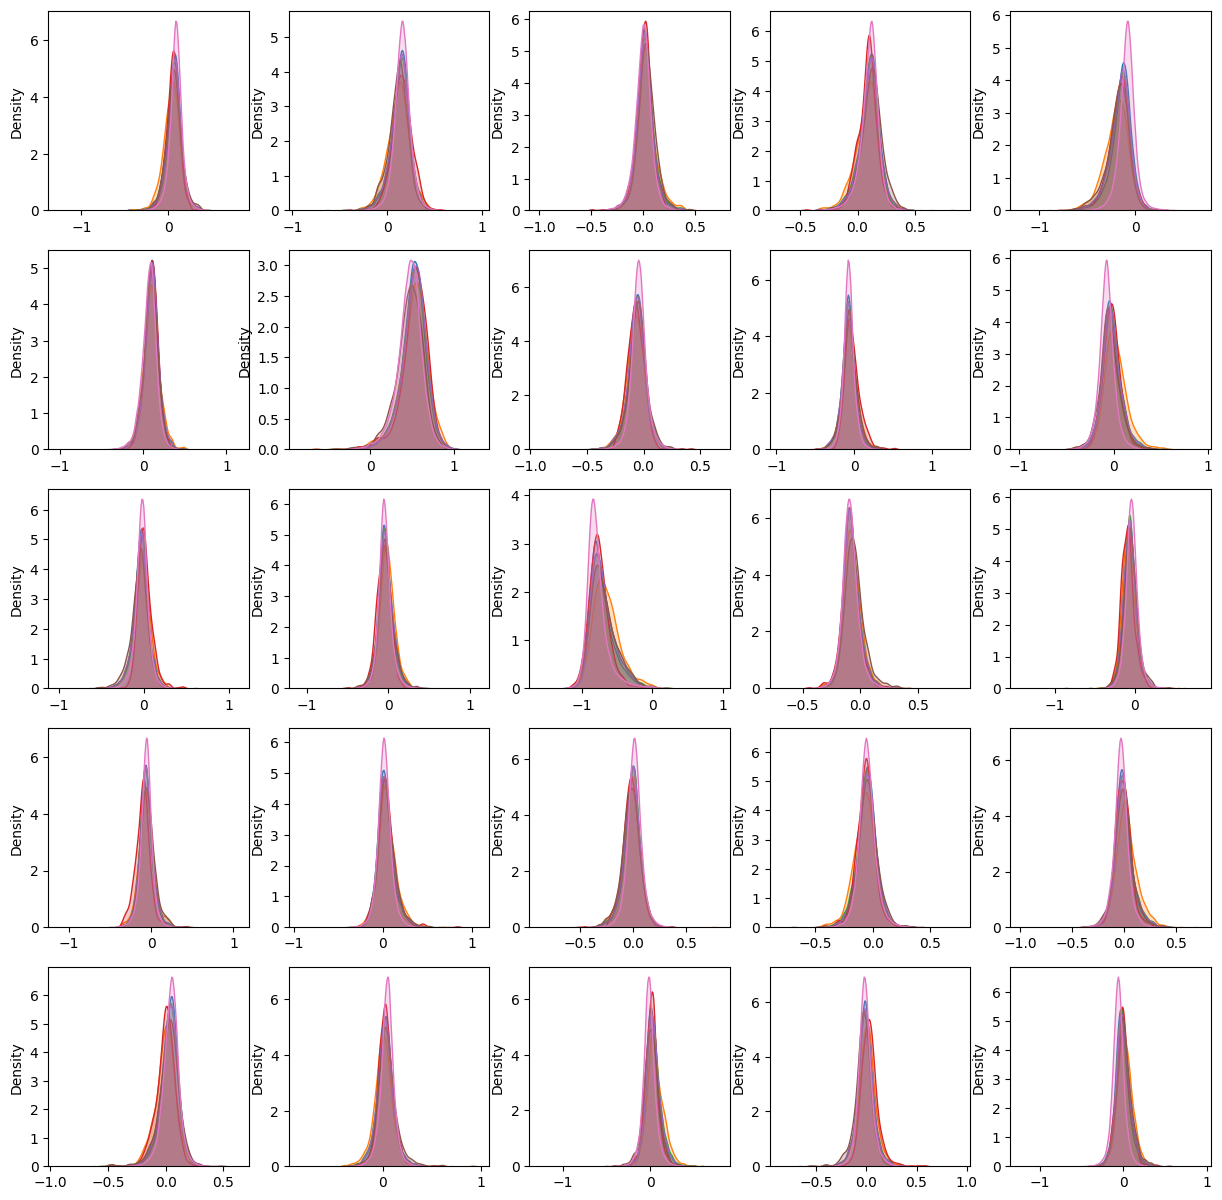

In [9]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_train[processed_train[label]==1].index.values
        li = list(map(lambda x: embeddings_glove[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_train[processed_train[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_glove[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

In [10]:
embeddings_glove = pd.DataFrame(embeddings_glove.tolist())

In [12]:
embeddings_glove[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']] = processed_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']]

In [13]:
embeddings_glove.head()

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0.020071,0.067968,-0.062794,0.045805,-0.026198,0.020383,0.394938,-0.045788,-0.071278,-0.078638,...,0.210889,-0.113697,-0.036887,0,0,0,0,0,0,1
1,0.085630,0.083147,-0.136207,0.008497,0.001106,0.109956,0.299174,-0.164092,-0.107027,-0.068148,...,0.164790,-0.044959,0.166523,0,0,0,0,0,0,1
2,0.108352,0.208866,-0.025381,0.109339,-0.099575,0.112354,0.582873,-0.029074,-0.069566,-0.112938,...,0.182581,-0.211230,-0.026443,0,0,0,0,0,0,1
3,0.042564,0.198714,-0.006755,0.121494,-0.086642,0.084517,0.527498,-0.066771,-0.103323,0.015370,...,0.188630,-0.015987,-0.102774,0,0,0,0,0,0,1
4,0.092235,0.236658,-0.054219,0.082956,-0.179523,0.100652,0.663226,0.062394,-0.112727,-0.010951,...,0.023308,0.038566,-0.071124,0,0,0,0,0,0,1


In [14]:
columns = LABELS + ['none']
features_glove = list(range(200))
rows_glove = [{c:embeddings_glove[f].corr(embeddings_glove[c]) for c in columns} for f in features_glove]
train_correlations_glove = pd.DataFrame(rows_glove, index=features_glove)

In [15]:
# set the threshold to be 0.2, meaning that the absolute value of correlation should at least 0.2 for at least one category
masking_glove = list(map(lambda x: abs(max(train_correlations_glove.iloc[x], key=abs))>0.2, range(len(train_correlations_glove))))

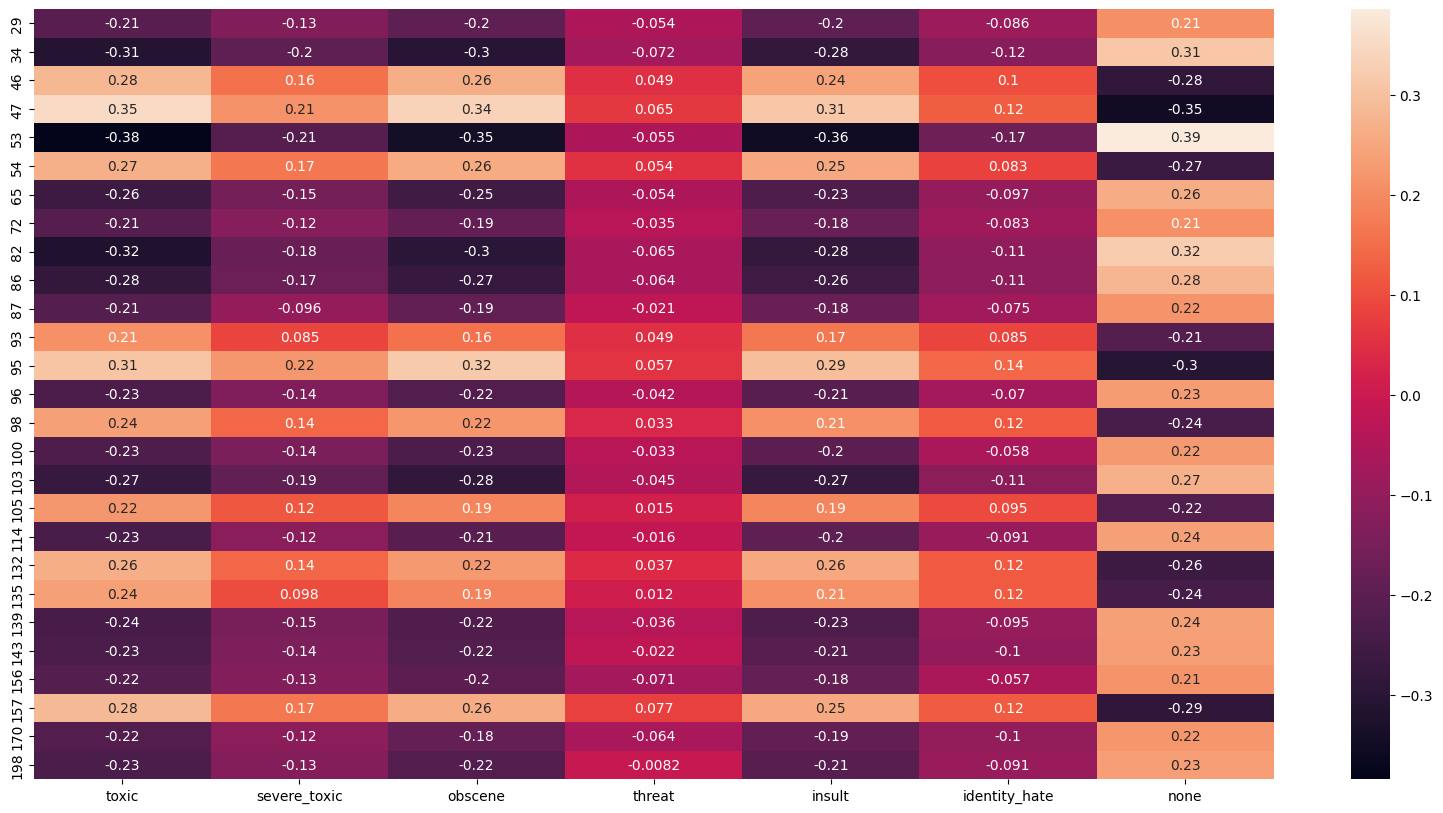

In [16]:
# top features from the GloVe--27 features in total
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations_glove[masking_glove], annot=True)
plt.show()

In [30]:
sum(masking_glove)

27

There are 27 dimensions with stronger correlations with the labels. However, these features have relatively low representability on severe_toxic, threat, and identity_hate categories.

In [17]:
embeddings_glove.to_csv('embeddings_glove.csv', index=False)

### FastText

Using FastText, each word, w, is represented as a bag of character n-gram. For example, given the word "introduce" and n = 3, FastText will produce the following representation composed of character tri-grams: < in, int, ntr, tro, rod, odu, duc, uce, ce > Note that the sequence, corresponding to the word here is different from the tri-gram "int" from the word introduce. Again, FastText is pre-trained on huge corpus (https://fasttext.cc/docs/en/english-vectors.html).

Advantages:
- Works for rare words, if their character n-grams which are still shared with other words
- Solves out of vocabulary words with n-gram in character level

Limitations:
- It cannot capture the meaning of the word from the text (fails to capture polysemy)

In [18]:
# build a FastText model - 300d
fasttext_path = "D:/GoogleDownloads/BT4222/crawl-300d-2M-subword/crawl-300d-2M-subword.vec"
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_path, binary=False, limit=30000000000) # load 30B most common words

In [29]:
# generate embedding vectors of size 300 using tokenized text (stop words and punctuation kept)
embeddings_fasttext = processed_train["text_tokenized_nopunc"].map(lambda x: get_embeddings(fasttext_model, x, 300))

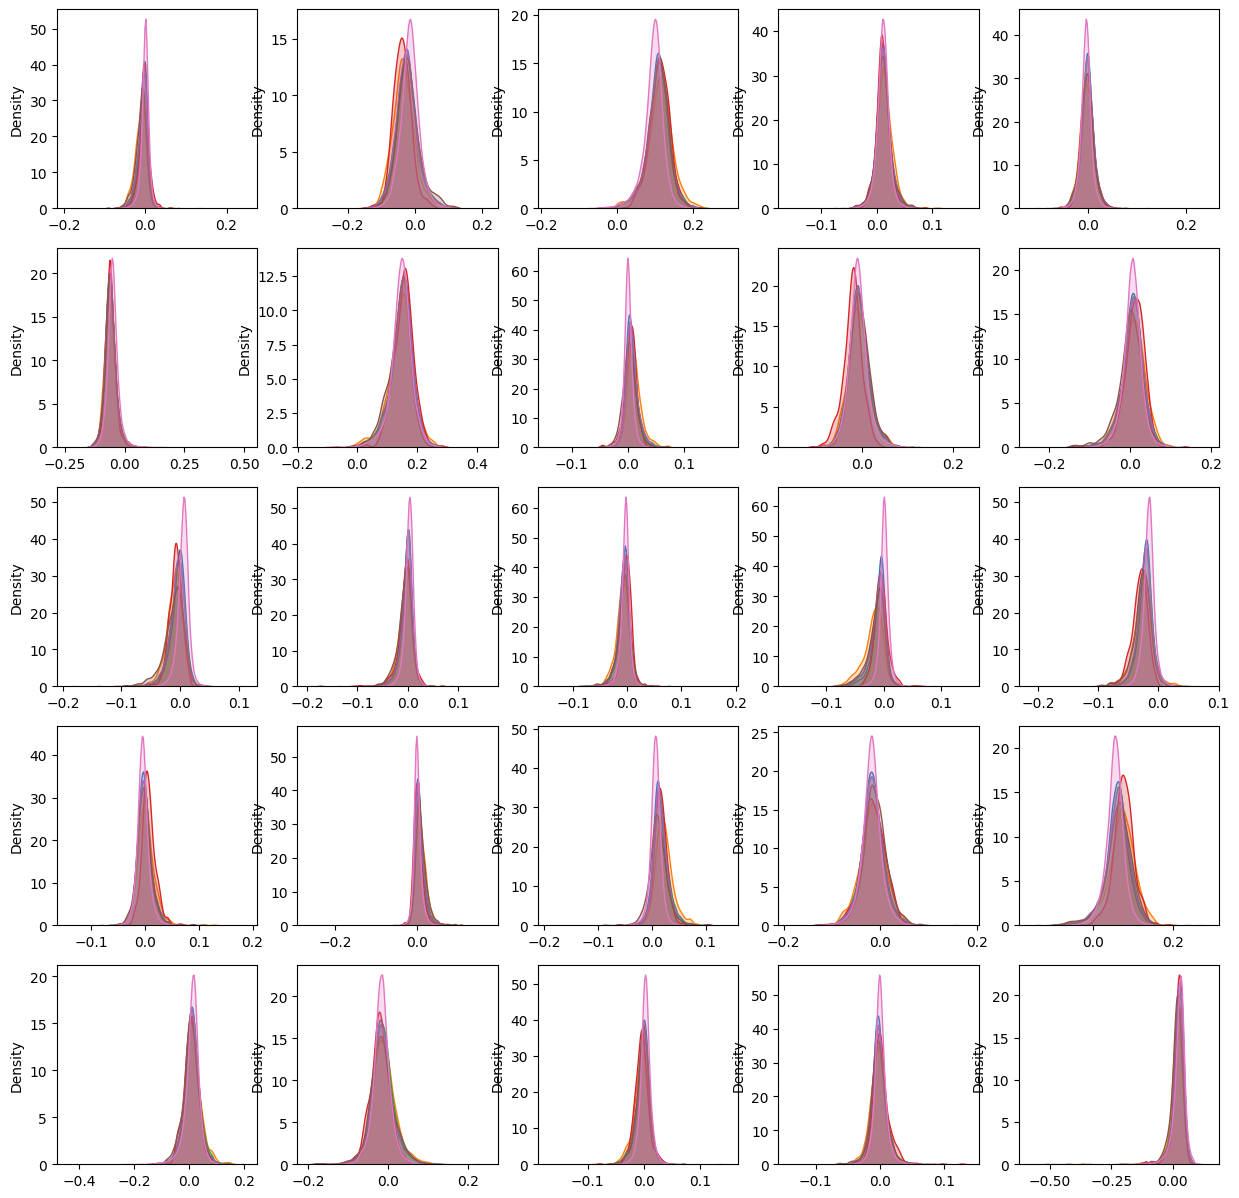

In [31]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_train[processed_train[label]==1].index.values
        li = list(map(lambda x: embeddings_fasttext[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_train[processed_train[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_fasttext[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

In [32]:
embeddings_fasttext = pd.DataFrame(embeddings_fasttext.tolist())

In [33]:
embeddings_fasttext[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']] = processed_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']]

In [34]:
embeddings_fasttext.head()

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,-0.011796,-0.034940,0.066037,0.005735,-0.005319,-0.038552,0.123421,-0.002952,-0.014212,-0.009029,...,0.002460,-0.001371,-0.005269,0,0,0,0,0,0,1
1,-0.007722,-0.030956,0.024328,0.017161,-0.007744,0.021033,0.059106,-0.003367,0.004111,0.014378,...,-0.015872,0.024333,0.015556,0,0,0,0,0,0,1
2,0.010314,-0.022707,0.106455,0.018339,-0.016986,-0.068418,0.182143,-0.003807,-0.008566,0.026127,...,-0.008361,-0.007125,-0.006475,0,0,0,0,0,0,1
3,-0.003618,-0.011934,0.118641,0.012609,-0.005242,-0.058996,0.157612,0.004858,-0.025896,0.028224,...,-0.011730,-0.007458,-0.007294,0,0,0,0,0,0,1
4,-0.003014,-0.019021,0.121900,0.012936,0.008143,-0.075914,0.211829,0.008764,-0.032014,0.019671,...,-0.034771,-0.009393,-0.011564,0,0,0,0,0,0,1


In [35]:
columns = LABELS + ['none']
features_fasttext = list(range(300))
rows_fasttext = [{c:embeddings_fasttext[f].corr(embeddings_fasttext[c]) for c in columns} for f in features_fasttext]
train_correlations_fasttext = pd.DataFrame(rows_fasttext, index=features_fasttext)

In [36]:
# set the threshold to be 0.2, meaning that the absolute value of correlation should at least 0.2 for at least one category
masking_fasttext = list(map(lambda x: abs(max(train_correlations_fasttext.iloc[x], key=abs))>0.2, range(len(train_correlations_fasttext))))

In [37]:
sum(masking_fasttext)

39

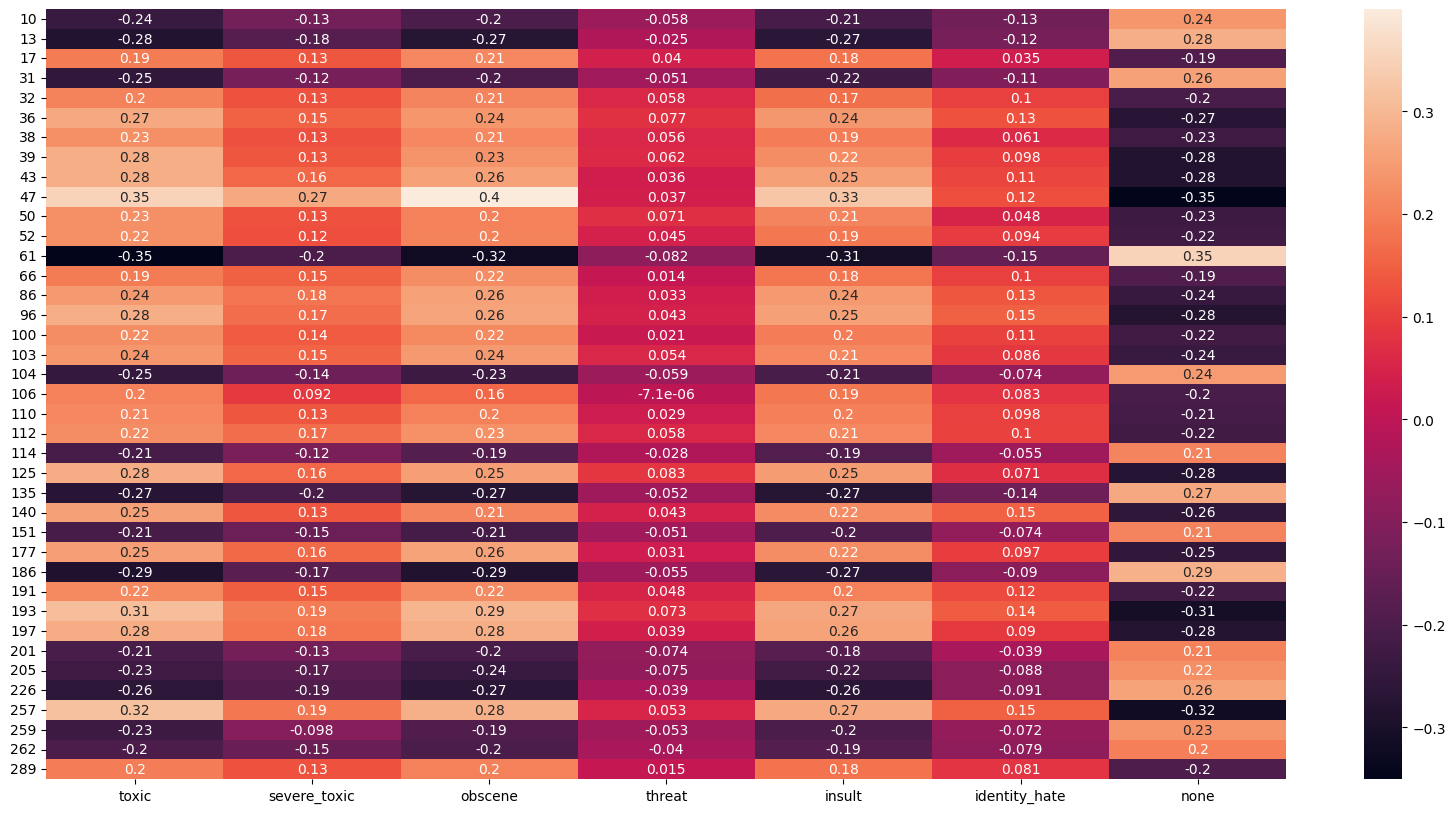

In [38]:
# top features from the FastText--39 features in total
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations_fasttext[masking_fasttext], annot=True)
plt.show()

Representability on severe_toxic is slightly better, but that of threat and identity_hate is still insufficient.

In [39]:
embeddings_fasttext.to_csv('embeddings_fasttext.csv', index=False)

## Sentence Embedding

A simple and straightforward baseline method for creating sentence vectors is to use a word embedding model to encode all the words of a given sentence and take the average of all the resulting vectors. While this provides a strong baseline, it falls short of capturing information related to word order and other aspects of overall sentence semantics. Therefore, we would like to try out a few sentence embedding methods to capture a range of semantic relationships between sentences.

BERT algorithm

Advantages:
-  It captures the meaning of the word from the text (incorporates context, handling polysemy)

Limitations:
- Computationally expensive
- It cannot capture out-of-vocabulary words from a corpus

While each word has a fixed representation under forementioned models regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them. We use the BERT base model to create sentence embeddings.

### SentenceBERT

SentenceBERT is one of the most popular packages for generating sentence embeddings based on transformer models such as BERT, RoBERTa, and DistilBERT (https://www.kdnuggets.com/2019/09/bert-roberta-distilbert-xlnet-one-use.html). We use roberta-base-nli-mean-tokens as the pre-trained model as it improves the performance of base BERT and is optimized for NLI tasks. (https://www.sbert.net/index.html)

In [63]:
# load pre-trained model tokenizer (vocabulary)
sbert_model = SentenceTransformer('roberta-base-nli-mean-tokens')

In [51]:
# prepare the input used for BERT model
sentence_tokenized = processed_train['clean_text']

In [112]:
# generate embedding vectors (stop words and punctuation kept)
start_time5 = time.time()
embeddings_sbert = []
# embed batch by batch
for i in range(10000, len(sentence_tokenized), 10000):
    text = sentence_tokenized[i-10000:i].values
    embedded_text = sbert_model.encode(text)
    embeddings_sbert = np.concatenate((embeddings_sbert, embedded_text)) if len(embeddings_sbert)!=0 else embedded_text
    print(f'The first {i} texts have been embedded')
# embed the last batch of text
text = sentence_tokenized[i:len(sentence_tokenized)].values
embedded_text = sbert_model.encode(text)
embeddings_sbert = np.concatenate((embeddings_sbert, embedded_text))
print("--- %s seconds ---" % (time.time() - start_time5))

The first 10000 texts have been embedded
The first 20000 texts have been embedded
The first 30000 texts have been embedded
The first 40000 texts have been embedded
The first 50000 texts have been embedded
The first 60000 texts have been embedded
The first 70000 texts have been embedded
The first 80000 texts have been embedded
The first 90000 texts have been embedded
The first 100000 texts have been embedded
The first 110000 texts have been embedded
The first 120000 texts have been embedded
The first 130000 texts have been embedded
The first 140000 texts have been embedded
The first 150000 texts have been embedded
--- 21910.65552687645 seconds ---


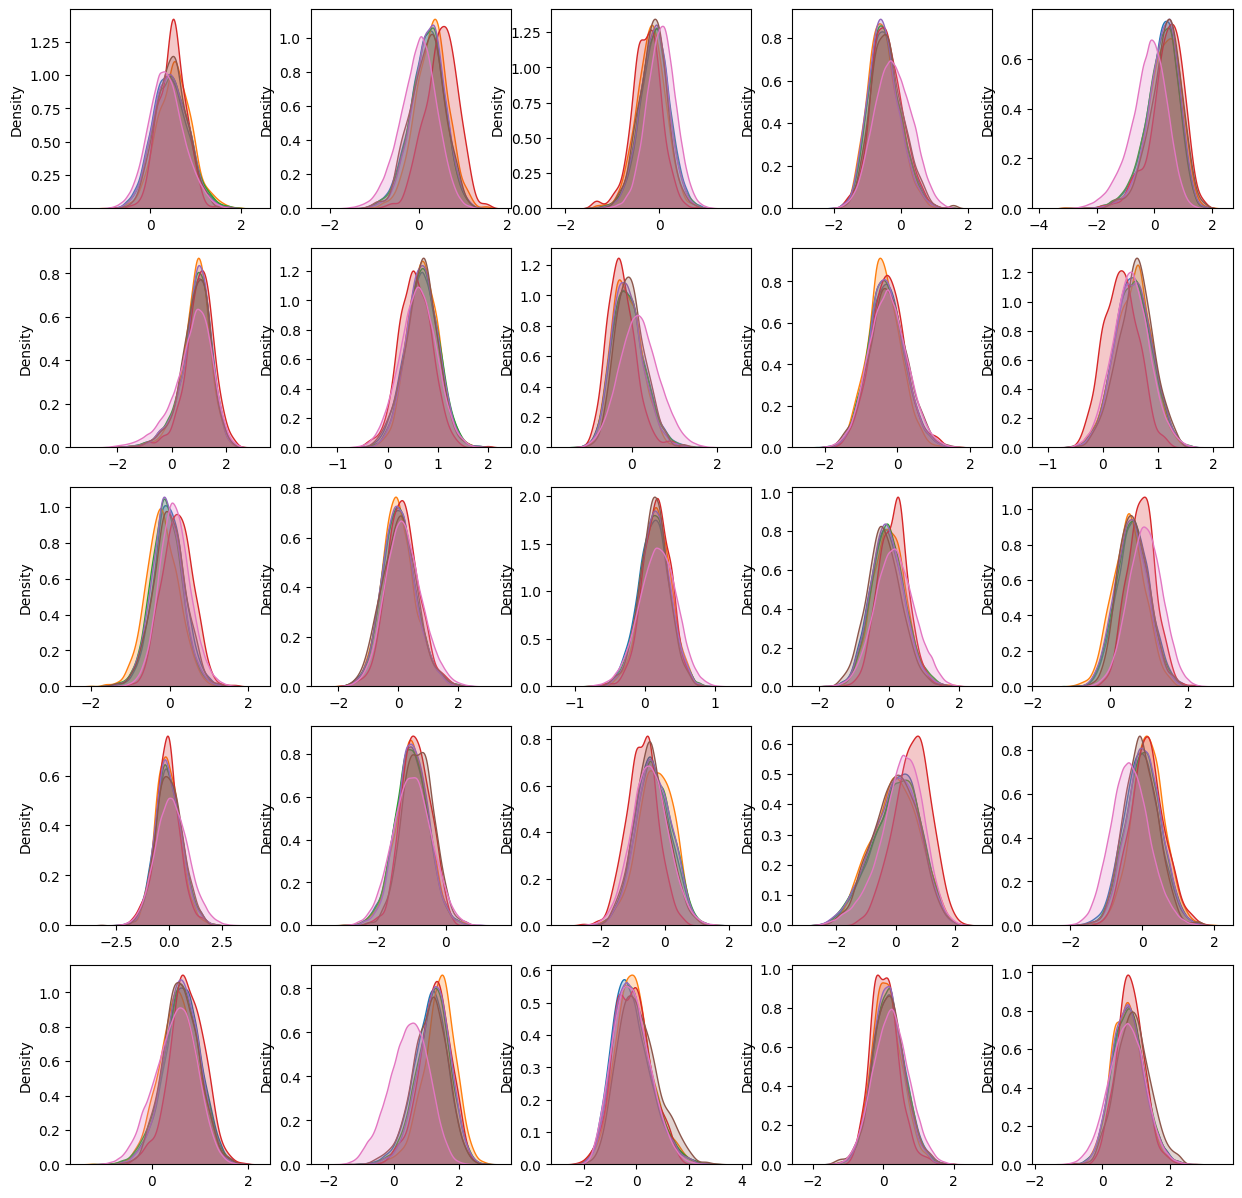

In [115]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_train[processed_train[label]==1].index.values
        li = list(map(lambda x: embeddings_sbert[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_train[processed_train[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_sbert[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

In [116]:
pd.DataFrame(embeddings_sbert).to_csv('embeddings_sbert.csv', index=False)

In [203]:
embeddings_sbert = pd.read_csv('embeddings_sbert.csv')

In [205]:
embeddings_sbert[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']] = processed_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']]

In [206]:
embeddings_sbert.head()

,0,1,2,3,4,5,6,7,8,9,...,765,766,767,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0.171917,0.244166,0.363185,-0.124087,0.019609,0.595354,1.297301,0.048164,-0.488295,0.556937,...,-2.186177,0.238404,1.409261,0,0,0,0,0,0,1
1,0.778325,-0.297249,0.136940,0.316015,-0.190891,-0.591988,0.669975,0.856241,0.178374,0.193833,...,-0.798215,0.326834,0.945351,0,0,0,0,0,0,1
2,0.375916,1.082368,-0.036319,0.006714,1.025224,0.923432,0.381920,-0.134765,0.767407,-0.160680,...,-1.784739,-0.565956,0.691820,0,0,0,0,0,0,1
3,0.006901,0.530308,0.486002,0.270731,-0.151900,1.036672,0.719169,0.524088,-1.012554,-0.055839,...,-1.935038,-0.175684,0.798193,0,0,0,0,0,0,1
4,0.424174,-0.605744,-0.523146,0.566048,-0.019225,1.639076,-0.234187,-0.059727,0.137457,0.399142,...,-0.684098,0.200720,0.452843,0,0,0,0,0,0,1


In [207]:
columns = LABELS + ['none']
features_sbert = list(map(str, range(768)))
rows_sbert = [{c:embeddings_sbert[f].corr(embeddings_sbert[c]) for c in columns} for f in features_sbert]
train_correlations_sbert = pd.DataFrame(rows_sbert, index=features_sbert)

In [214]:
# set the threshold to be 0.2, meaning that the absolute value of correlation should at least 0.2 for at least one category
masking_sbert = list(map(lambda x: abs(max(train_correlations_sbert.iloc[x], key=abs))>0.2, range(len(train_correlations_sbert))))

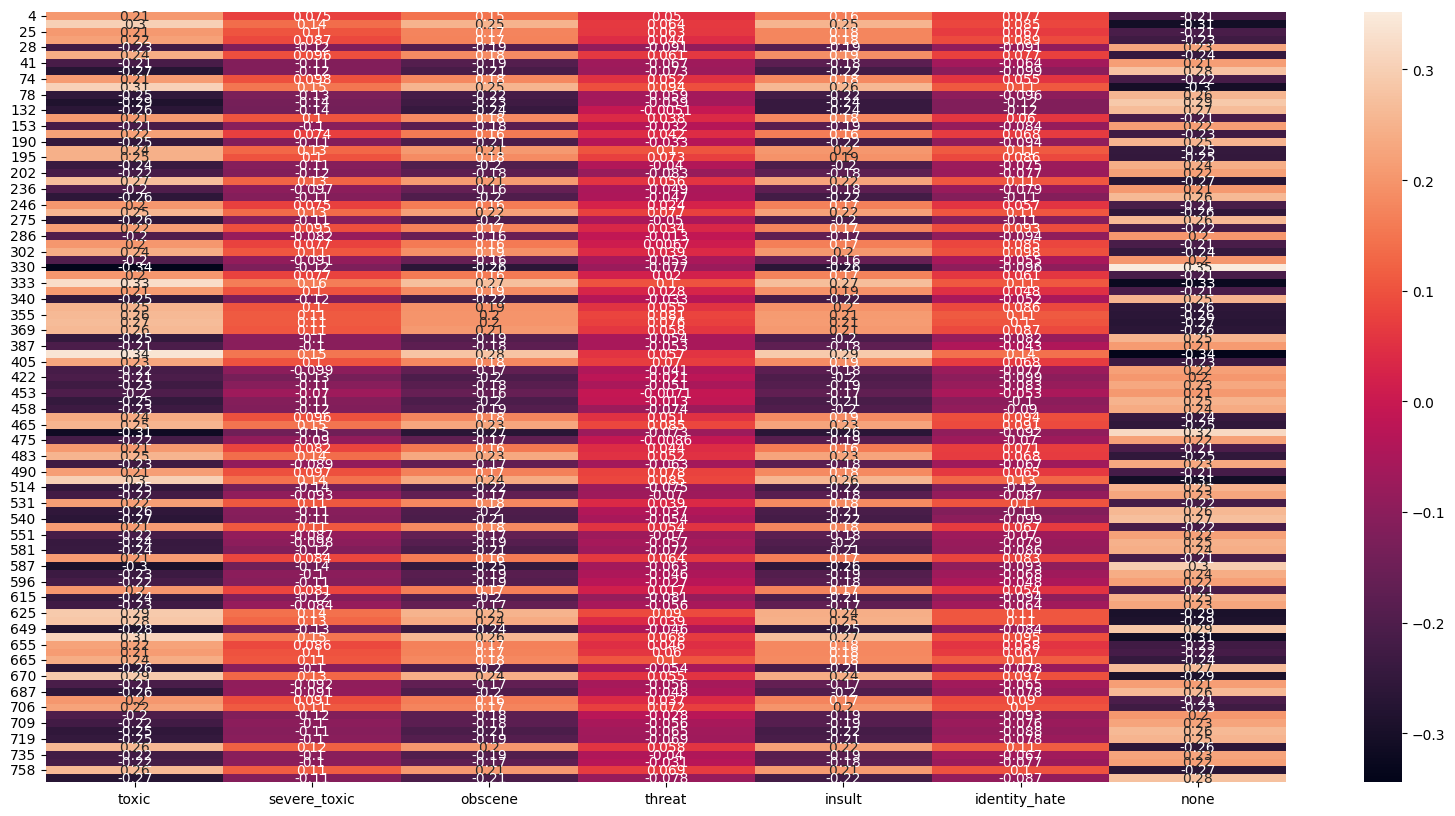

In [209]:
# top features from the SentenceBERT--98 features in total
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations_sbert[masking_sbert], annot=True)
plt.show()

SentenceBERT gives the most useful features, but the representability issue still persists.

### BERTweet

BERTweet is the first public large-scale pre-trained language model for English Tweets. BERTweet has the same architecture as BERT-base, is trained using the RoBERTa pre-training procedure. Experiments show that BERTweet outperforms strong baselines RoBERTa-base and XLM-R-base, producing better performance results than the previous state-of-the-art models on three Tweet NLP tasks: Part-of-speech tagging, Named-entity recognition and text classification. (https://github.com/VinAIResearch/BERTweet)

In [4]:
# load pre-trained model (weights)
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")

# load pre-trained model tokenizer (vocabulary)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
# prepare the input used for BERT model
sentence_tokenized = processed_train['clean_text']

In [8]:
# generate embedding vectors (stop words and punctuation kept)
start_time6 = time.time()
embeddings_bertweet = []
# embed batch by batch (due to CPU limit, the batch size needs to be small)
for i in range(1000, len(sentence_tokenized), 1000):
    text = sentence_tokenized[i-1000:i].values
    tokenized_text = tokenizer.batch_encode_plus(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = bertweet(**tokenized_text)
        embedded_text = outputs.last_hidden_state.mean(dim=1)
        embeddings_bertweet = np.concatenate((embeddings_bertweet, embedded_text)) if len(embeddings_bertweet)!=0 else embedded_text
# embed the last batch of text
text = sentence_tokenized[i:len(sentence_tokenized)].values
tokenized_text = tokenizer.batch_encode_plus(text, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    outputs = bertweet(**tokenized_text)
    embedded_text = outputs.last_hidden_state.mean(dim=1)
    embeddings_bertweet = np.concatenate((embeddings_bertweet, embedded_text))
print("--- %s seconds ---" % (time.time() - start_time6))

--- 35302.47935342789 seconds ---


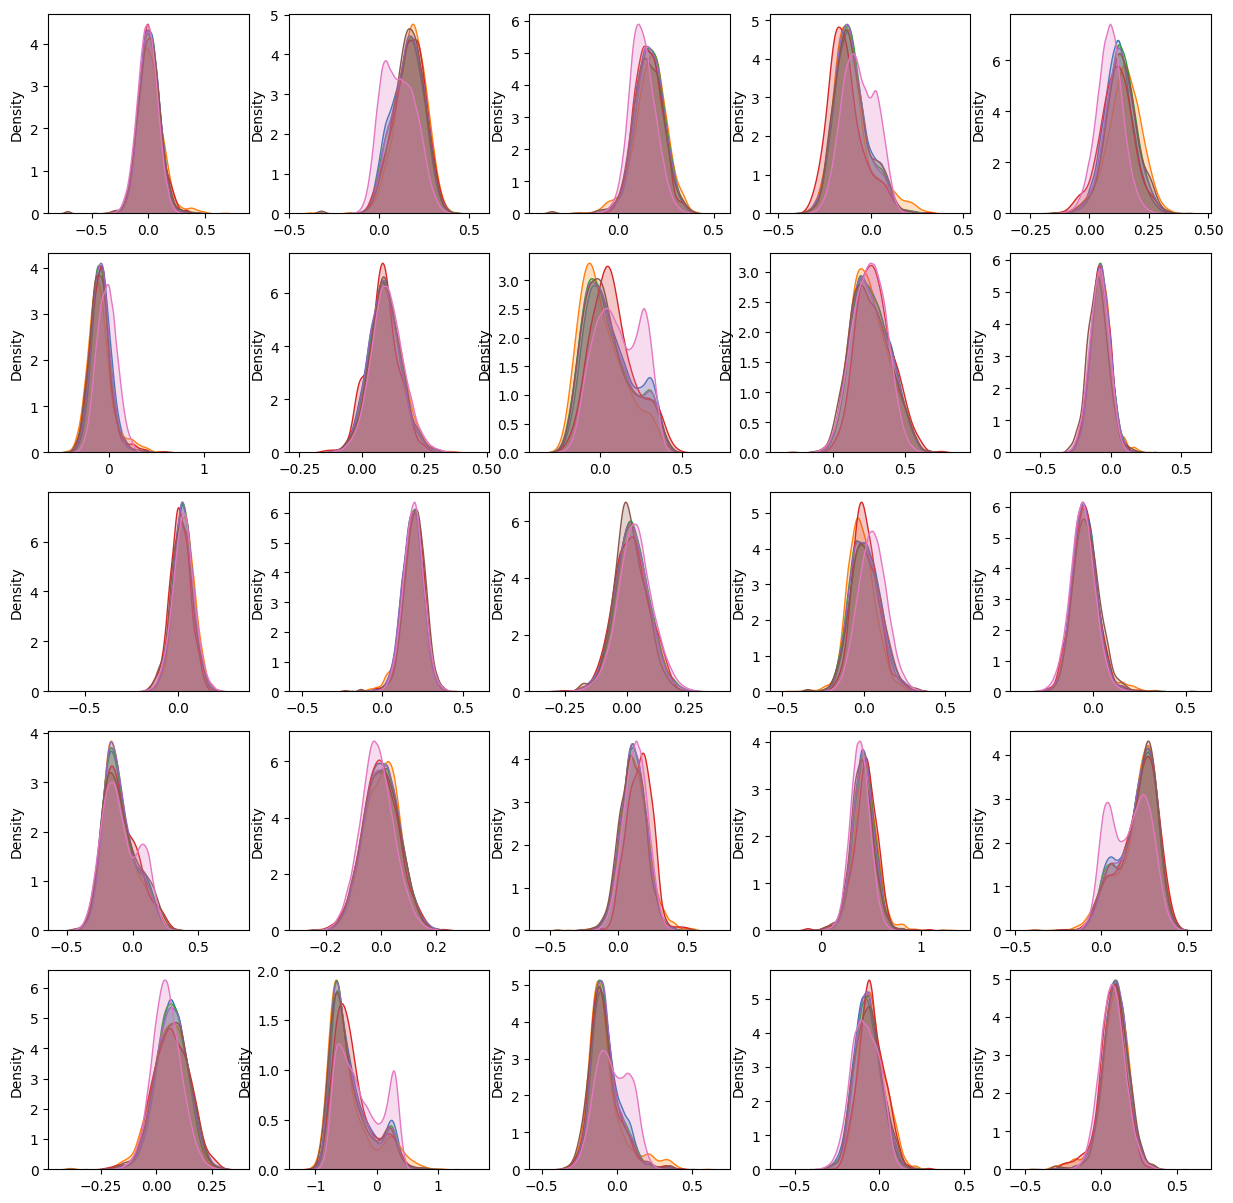

In [9]:
# plot the result of embeddings
fig, axes = plt.subplots(nrows = 5, ncols=5, figsize=(15,15))
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for dim in range(25):
    for label in labels:
        idx = processed_train[processed_train[label]==1].index.values
        li = list(map(lambda x: embeddings_bertweet[x][dim], idx))
        sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])
    idx = processed_train[processed_train[labels].sum(axis=1)==0].index.values
    li = list(map(lambda x: embeddings_bertweet[x][dim], idx))
    sns.kdeplot(li, fill=True, ax=axes[dim//5,dim%5])

In [10]:
pd.DataFrame(embeddings_bertweet).to_csv('embeddings_bertweet.csv', index=False)

In [161]:
embeddings_bertweet = pd.read_csv('embeddings_bertweet.csv')

In [192]:
embeddings_bertweet[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']] = processed_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']]

In [202]:
embeddings_bertweet.head()

,0,1,2,3,4,5,6,7,8,9,...,765,766,767,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,-0.089075,0.147721,0.172414,-0.090819,0.085112,0.010012,0.193164,0.095004,0.205394,-0.072653,...,0.019752,0.116295,-0.034492,0,0,0,0,0,0,1
1,-0.058158,0.177169,-0.020692,-0.101573,0.108007,0.005104,0.010756,0.090973,0.068879,-0.161702,...,0.068354,0.039289,-0.133114,0,0,0,0,0,0,1
2,0.148364,-0.002536,0.143607,-0.191694,0.127024,0.006462,0.104901,0.101011,0.063099,-0.064463,...,-0.023991,0.118896,-0.076376,0,0,0,0,0,0,1
3,0.077268,-0.078746,-0.018971,0.018293,0.068306,0.127851,0.060821,0.313522,0.313104,-0.011692,...,0.024826,0.087176,0.056098,0,0,0,0,0,0,1
4,0.043168,0.187559,0.116049,-0.081296,0.029947,-0.058032,0.094284,-0.033769,0.136660,-0.132549,...,-0.012794,0.049963,-0.027657,0,0,0,0,0,0,1


In [193]:
columns = LABELS + ['none']
features_bertweet = list(map(str, range(768)))
rows_bertweet = [{c:embeddings_bertweet[f].corr(embeddings_bertweet[c]) for c in columns} for f in features_bertweet]
train_correlations_bertweet = pd.DataFrame(rows_bertweet, index=features_bertweet)

In [200]:
# set the threshold to be 0.2, meaning that the absolute value of correlation should at least 0.2 for at least one category
masking_bertweet = list(map(lambda x: abs(max(train_correlations_bertweet.iloc[x], key=abs))>0.2, range(len(train_correlations_bertweet))))

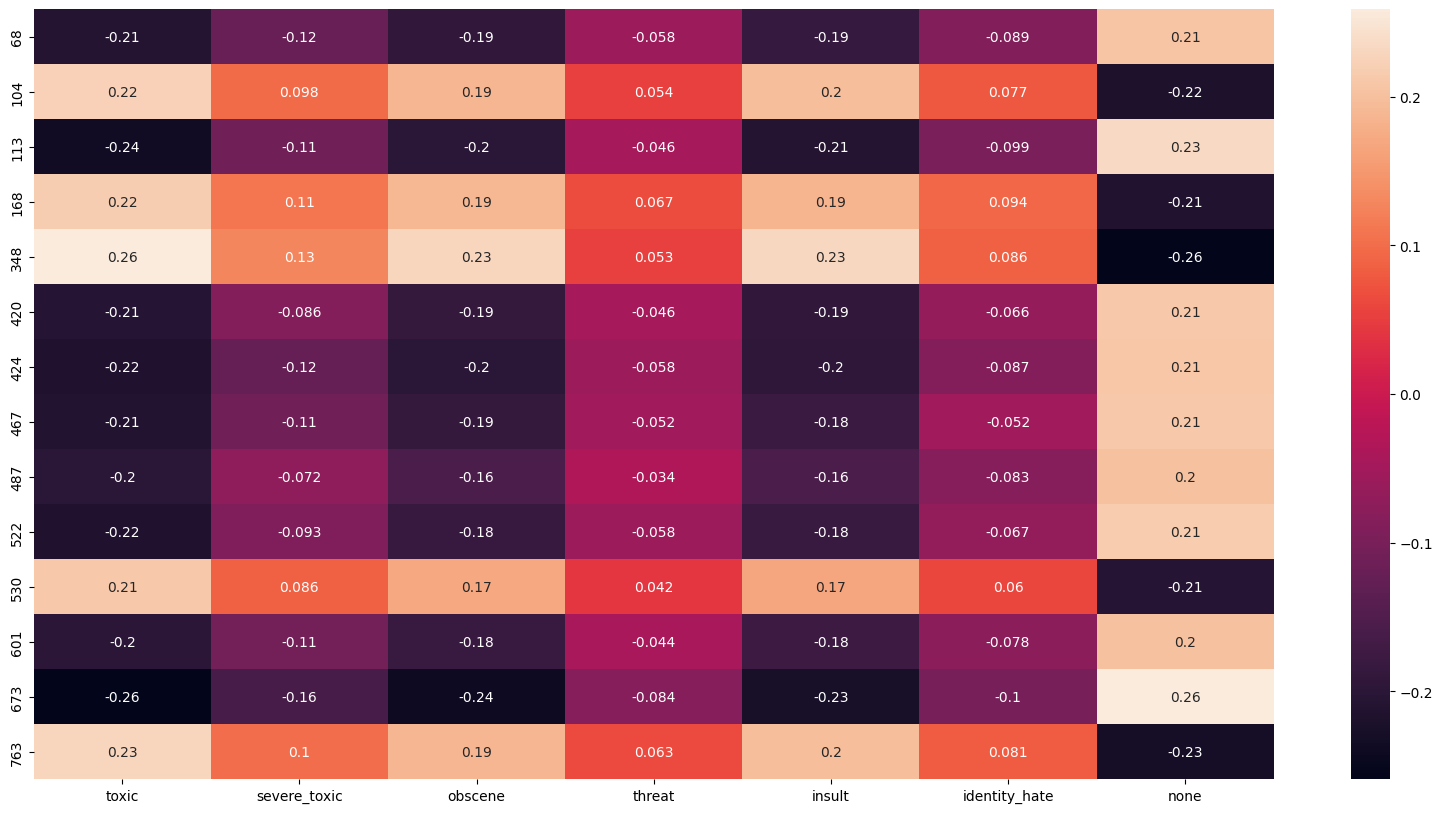

In [201]:
# top features from the BERTweet--14 features in total
plt.figure(figsize = (20,10))
sns.heatmap(train_correlations_bertweet[masking_bertweet], annot=True)
plt.show()

BERTweet doesn't seem to perform well, despite some differences indistribution shown in graphs.

In [41]:
print(f'ratio of useful features:\n  \
GloVe: {27/200}\n  \
FastText: {39/300}\n  \
SentenceBERT: {98/768}\n  \
BERTweet: {14/768}')

ratio of useful features:
  GloVe: 0.135
  FastText: 0.13
  SentenceBERT: 0.12760416666666666
  BERTweet: 0.018229166666666668


## Store the selected data

In [2]:
embeddings_glove = pd.read_csv('embeddings_glove.csv')

In [6]:
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
columns = LABELS + ['none']
features_glove = list(map(str, (range(200))))
rows_glove = [{c:embeddings_glove[f].corr(embeddings_glove[c]) for c in columns} for f in features_glove]
train_correlations_glove = pd.DataFrame(rows_glove, index=features_glove)

In [7]:
# set the threshold to be 0.2, meaning that the absolute value of correlation should at least 0.2 for at least one category
masking_glove = list(map(lambda x: abs(max(train_correlations_glove.iloc[x], key=abs))>0.2, range(len(train_correlations_glove))))

In [16]:
# selected features
index = train_correlations_glove[masking_glove].index

In [17]:
embeddings_glove[index].head()

,29,34,46,47,53,54,65,72,82,86,...,105,114,132,135,139,143,156,157,170,198
0,-0.054548,-0.105844,-0.023651,-0.120931,0.029694,0.000656,0.138915,-0.011885,0.066578,-0.030327,...,-0.091320,-0.017755,0.003997,-0.199211,-0.109984,0.089084,0.012651,-0.019501,-0.091946,-0.113697
1,0.104774,-0.020276,0.102398,-0.146403,0.014844,0.019279,0.066769,0.092921,-0.116742,0.059807,...,-0.118445,0.039541,0.017522,0.001397,0.000094,0.021135,0.039308,-0.067295,-0.079366,-0.044959
2,0.022507,-0.155533,0.175771,0.021757,-0.035649,-0.149408,0.170970,0.032876,0.040762,-0.089416,...,-0.131555,-0.060714,0.026459,-0.029582,-0.146134,0.109907,0.036539,-0.053628,0.027530,-0.211230
3,0.028492,-0.103913,0.071215,-0.131409,0.066988,-0.070037,0.184324,0.047017,0.000166,-0.044984,...,-0.145382,-0.004285,-0.000706,-0.134984,-0.214832,0.177560,0.007675,-0.087473,0.106848,-0.015987
4,0.078496,-0.047719,0.130365,-0.037535,-0.104838,0.131475,0.138012,0.020882,0.027521,-0.151158,...,0.007073,-0.204627,0.162032,0.013798,-0.221076,0.163578,-0.068310,-0.031184,-0.017280,0.038566


In [19]:
embeddings_glove[index].describe()

,29,34,46,47,53,54,65,72,82,86,...,105,114,132,135,139,143,156,157,170,198
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,...,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.030404,-0.083993,0.106148,-0.080030,-0.043187,-0.031777,0.120529,0.041046,0.065246,-0.015938,...,-0.123168,-0.027823,0.035121,-0.112857,-0.189144,0.137551,0.048397,-0.051675,0.006696,-0.067698
std,0.096484,0.114167,0.129176,0.092261,0.098875,0.109849,0.101154,0.097534,0.110630,0.089607,...,0.088892,0.096866,0.091599,0.100583,0.106728,0.082682,0.114540,0.084850,0.103663,0.083965
min,-0.954390,-1.189472,-1.043850,-0.931120,-1.384900,-0.765360,-1.136968,-1.187796,-0.961870,-0.925060,...,-1.100143,-1.199205,-1.094000,-1.031195,-1.021500,-1.219800,-0.998550,-0.971725,-0.875290,-0.934250
25%,-0.019393,-0.141223,0.031291,-0.132792,-0.086474,-0.099390,0.066967,-0.008514,0.006077,-0.059983,...,-0.172676,-0.081497,-0.017672,-0.168614,-0.245270,0.099259,-0.015485,-0.100364,-0.050507,-0.109873
50%,0.034746,-0.079746,0.105464,-0.086882,-0.034002,-0.043011,0.126019,0.043507,0.069139,-0.010672,...,-0.127845,-0.029764,0.029416,-0.118701,-0.190440,0.143895,0.058521,-0.056001,0.011410,-0.066890
75%,0.083676,-0.021450,0.178145,-0.037987,0.012011,0.021495,0.180102,0.094417,0.129260,0.033863,...,-0.078294,0.024415,0.081428,-0.062976,-0.132827,0.183569,0.121490,-0.009563,0.067963,-0.023115
max,0.853917,1.202900,1.307795,0.857062,1.028000,1.067160,0.988435,0.934790,1.045900,0.783375,...,0.881510,0.950015,1.384300,1.070100,0.720593,0.949910,1.131500,1.106200,1.014500,1.241601


In [14]:
selected_train = pd.read_csv('Data/selected_train.csv')

In [20]:
selected_train = pd.concat([selected_train, embeddings_glove[index]], axis=1)

In [21]:
selected_train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,min_length_scaled,num_words_vs_length,exclamation_marks_vs_length,...,105,114,132,135,139,143,156,157,170,198
0,0,0,0,0,0,0,1,0.009393,0.181132,0.000000,...,-0.091320,-0.017755,0.003997,-0.199211,-0.109984,0.089084,0.012651,-0.019501,-0.091946,-0.113697
1,0,0,0,0,0,0,1,0.000723,0.160714,0.008929,...,-0.118445,0.039541,0.017522,0.001397,0.000094,0.021135,0.039308,-0.067295,-0.079366,-0.044959
2,0,0,0,0,0,0,1,0.007225,0.188841,0.000000,...,-0.131555,-0.060714,0.026459,-0.029582,-0.146134,0.109907,0.036539,-0.053628,0.027530,-0.211230
3,0,0,0,0,0,0,1,0.007948,0.175719,0.000000,...,-0.145382,-0.004285,-0.000706,-0.134984,-0.214832,0.177560,0.007675,-0.087473,0.106848,-0.015987
4,0,0,0,0,0,0,1,0.003613,0.208955,0.000000,...,0.007073,-0.204627,0.162032,0.013798,-0.221076,0.163578,-0.068310,-0.031184,-0.017280,0.038566


In [22]:
selected_train.to_csv('Data/selected_train.csv', index=False)